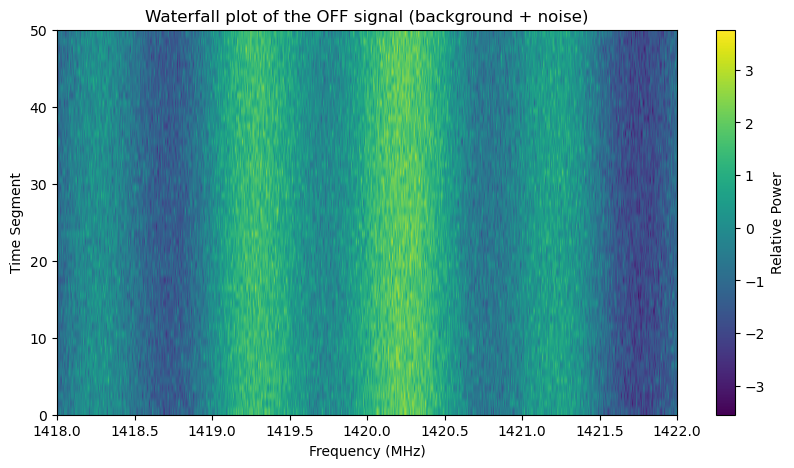

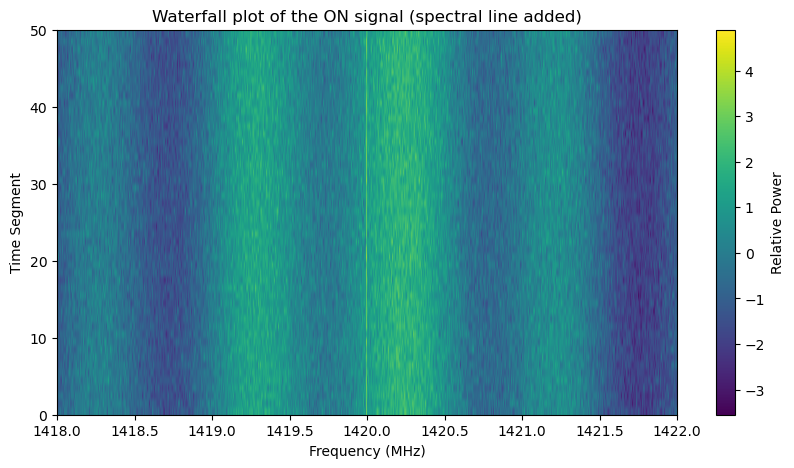

In [1]:
###STEP ONE
import numpy as np
import matplotlib.pyplot as plt

# 1. Set up the parameters
num_samples = 1000  # Number of frequency samples
frequency_range = np.linspace(1418, 1422, num_samples)  # Frequency range containing 1420 MHz
time_segments = 50  # Number of time segments (for the waterfall plot)
np.random.seed(42)  # For reproducibility

# 2. Create the background signal (smooth function)
background_signal = np.sin((frequency_range - 1420) * 2 * np.pi) + np.cos((frequency_range - 1420) * np.pi / 2)

# 3. Add Gaussian noise
def add_noise(signal, noise_level=0.5):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

# Generate the "off" signal (background + noise)
off_signal = np.array([add_noise(background_signal) for _ in range(time_segments)])

# 4. Create the "on" signal by adding a spectral line at 1420 MHz
spectral_line_position = np.abs(frequency_range - 1420).argmin()
spectral_amplitude = 3  # Strength of the spectral line
on_signal = np.copy(off_signal)
for i in range(time_segments):
    on_signal[i, spectral_line_position] += spectral_amplitude  # Add spectral line to "on" signal

# 5. Visualize the "off" signal (background + noise)
plt.figure(figsize=(10, 5))
plt.title('Waterfall plot of the OFF signal (background + noise)')
plt.imshow(off_signal, aspect='auto', extent=[frequency_range.min(), frequency_range.max(), 0, time_segments], cmap='viridis')
plt.colorbar(label='Relative Power')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time Segment')
plt.show()

# 6. Visualize the "on" signal (with the spectral line)
plt.figure(figsize=(10, 5))
plt.title('Waterfall plot of the ON signal (spectral line added)')
plt.imshow(on_signal, aspect='auto', extent=[frequency_range.min(), frequency_range.max(), 0, time_segments], cmap='viridis')
plt.colorbar(label='Relative Power')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time Segment')
plt.show()


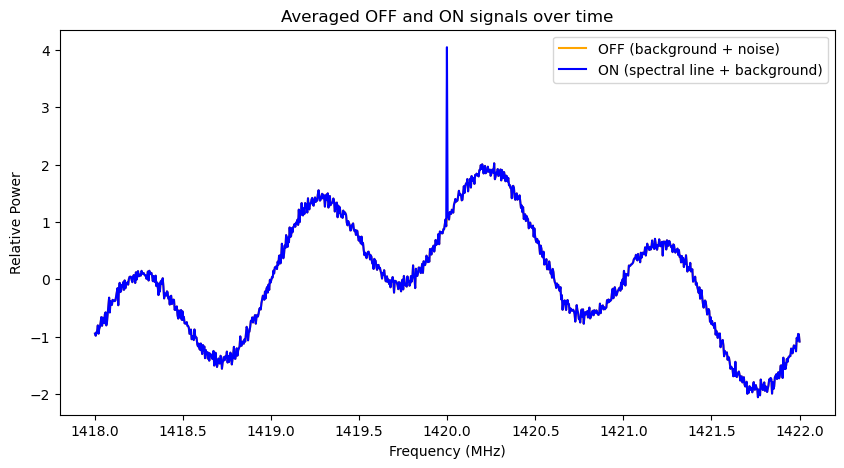

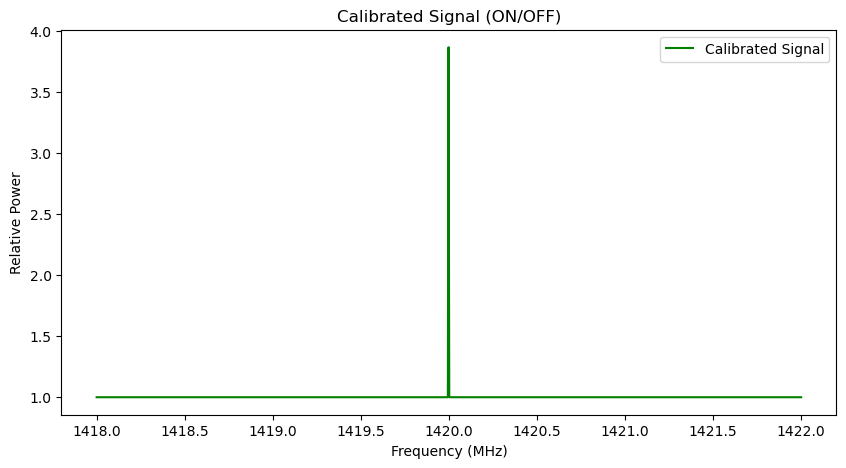

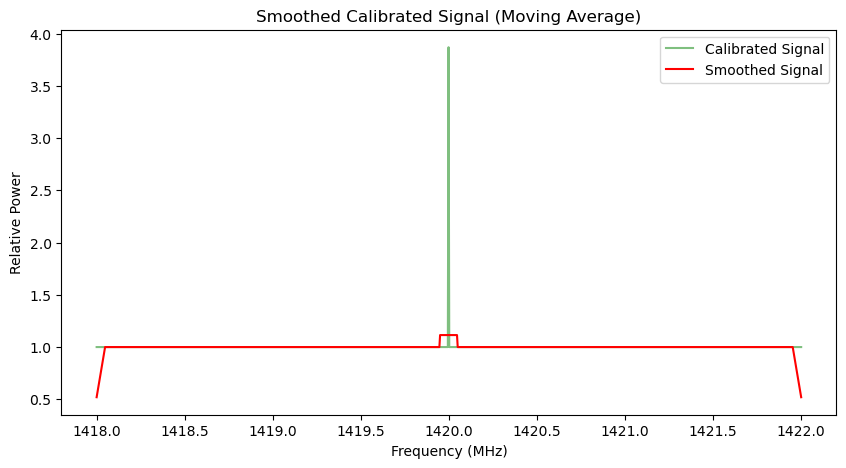

In [2]:
##STEP 2
# 1. Averaging over time (find the average signal for both "on" and "off" signals)
average_off_signal = np.mean(off_signal, axis=0)
average_on_signal = np.mean(on_signal, axis=0)

# Visualize the averaged signals
plt.figure(figsize=(10, 5))
plt.title('Averaged OFF and ON signals over time')
plt.plot(frequency_range, average_off_signal, label='OFF (background + noise)', color='orange')
plt.plot(frequency_range, average_on_signal, label='ON (spectral line + background)', color='blue')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

# 2. Calibrating the signal (removing the background)
calibrated_signal = average_on_signal / average_off_signal

# Visualize the calibrated signal
plt.figure(figsize=(10, 5))
plt.title('Calibrated Signal (ON/OFF)')
plt.plot(frequency_range, calibrated_signal, label='Calibrated Signal', color='green')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

# 3. Apply a moving average to smooth the calibrated signal
def moving_average(signal, N):
    return np.convolve(signal, np.ones(N)/N, mode='same')

# Choose a small N (a small percentage of total samples)
N = 25  # You can adjust this value based on the level of smoothing you want
smoothed_signal = moving_average(calibrated_signal, N)

# Visualize the smoothed signal
plt.figure(figsize=(10, 5))
plt.title('Smoothed Calibrated Signal (Moving Average)')
plt.plot(frequency_range, calibrated_signal, label='Calibrated Signal', color='green', alpha=0.5)
plt.plot(frequency_range, smoothed_signal, label='Smoothed Signal', color='red')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()


Spectral line detected at frequency: 1419.95 MHz


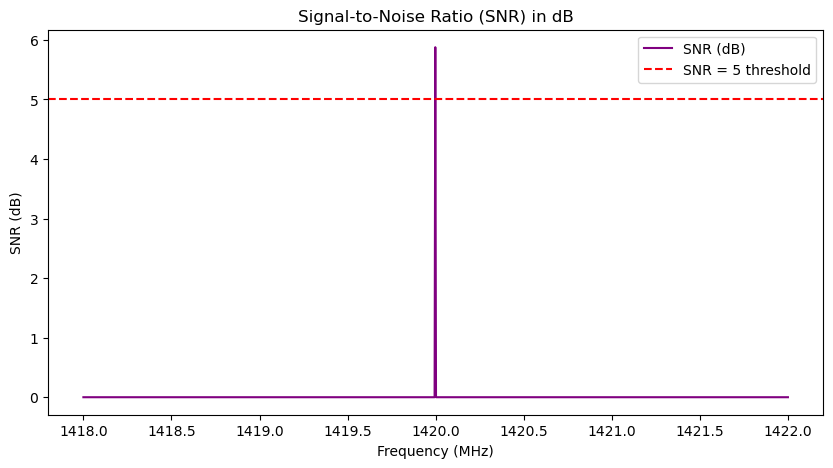

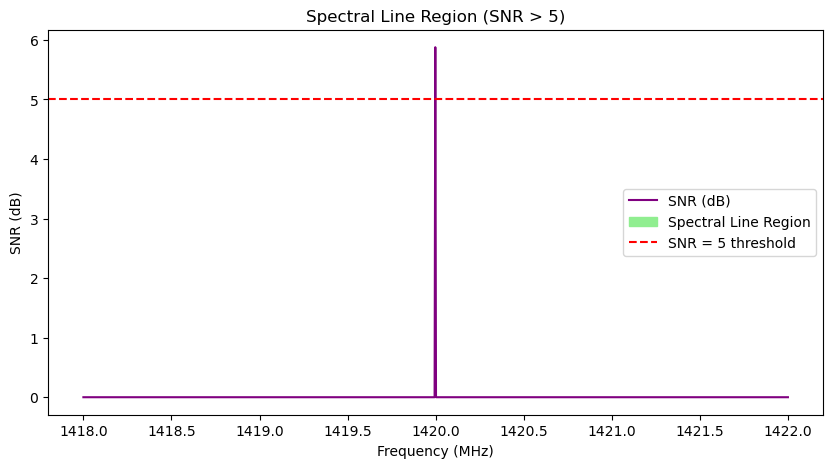

Spectral line region detected between 1420.00 MHz and 1420.00 MHz


In [3]:
##STEP 3
# 1. Identify the peak of the spectral line (we expect it near 1420 MHz)
spectral_peak_index = np.argmax(smoothed_signal)
spectral_peak_frequency = frequency_range[spectral_peak_index]
print(f"Spectral line detected at frequency: {spectral_peak_frequency:.2f} MHz")

# 2. Calculate Signal-to-Noise Ratio (SNR)
# Use the "on" signal as signal power (Psignal) and "off" signal as noise power (Pnoise)
P_signal = average_on_signal
P_noise = average_off_signal

# SNR in linear scale
SNR = P_signal / P_noise

# SNR in decibels (dB)
SNR_db = 10 * np.log10(SNR)

# Visualize the SNR
plt.figure(figsize=(10, 5))
plt.title('Signal-to-Noise Ratio (SNR) in dB')
plt.plot(frequency_range, SNR_db, label='SNR (dB)', color='purple')
plt.axhline(y=5, color='red', linestyle='--', label='SNR = 5 threshold')
plt.xlabel('Frequency (MHz)')
plt.ylabel('SNR (dB)')
plt.legend()
plt.show()

# 3. Identify the region where SNR > 5 (this defines the spectral line region)
snr_threshold = 5  # The threshold for detecting the spectral line
spectral_region = frequency_range[SNR_db > snr_threshold]

# Visualize the spectral region with SNR > 5
plt.figure(figsize=(10, 5))
plt.title('Spectral Line Region (SNR > 5)')
plt.plot(frequency_range, SNR_db, label='SNR (dB)', color='purple')
plt.fill_between(frequency_range, SNR_db, where=(SNR_db > snr_threshold), color='lightgreen', label='Spectral Line Region')
plt.axhline(y=snr_threshold, color='red', linestyle='--', label='SNR = 5 threshold')
plt.xlabel('Frequency (MHz)')
plt.ylabel('SNR (dB)')
plt.legend()
plt.show()

print(f"Spectral line region detected between {spectral_region.min():.2f} MHz and {spectral_region.max():.2f} MHz")


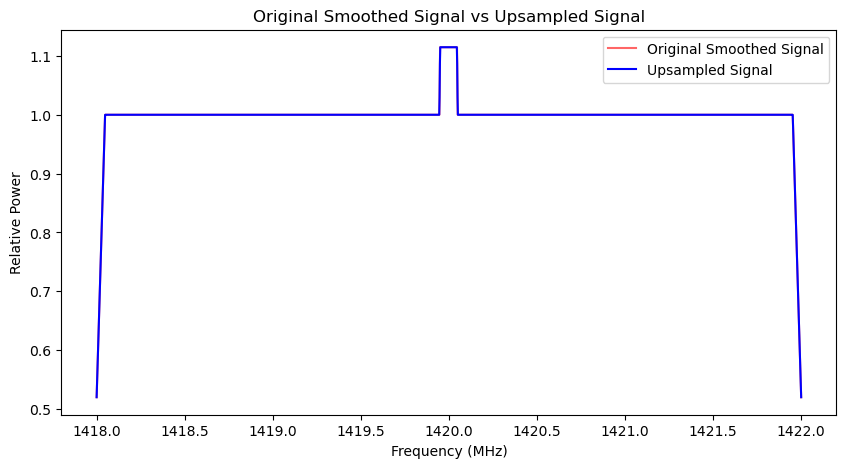

Original signal had 1000 samples.
Upsampled signal has 2000 samples.


In [4]:
##STEP 4
from scipy.interpolate import interp1d

# 1. Perform linear interpolation to upsample the smoothed signal
upsample_factor = 2  # You can increase this factor for higher resolution
new_num_samples = num_samples * upsample_factor  # New number of frequency points after upsampling
new_frequency_range = np.linspace(frequency_range.min(), frequency_range.max(), new_num_samples)

# Interpolate using linear interpolation
linear_interpolator = interp1d(frequency_range, smoothed_signal, kind='linear')

# Generate the upsampled signal
upsampled_signal = linear_interpolator(new_frequency_range)

# 2. Visualize the original smoothed signal and the upsampled signal
plt.figure(figsize=(10, 5))
plt.title('Original Smoothed Signal vs Upsampled Signal')
plt.plot(frequency_range, smoothed_signal, label='Original Smoothed Signal', color='red', alpha=0.6)
plt.plot(new_frequency_range, upsampled_signal, label='Upsampled Signal', color='blue')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

print(f"Original signal had {num_samples} samples.")
print(f"Upsampled signal has {new_num_samples} samples.")


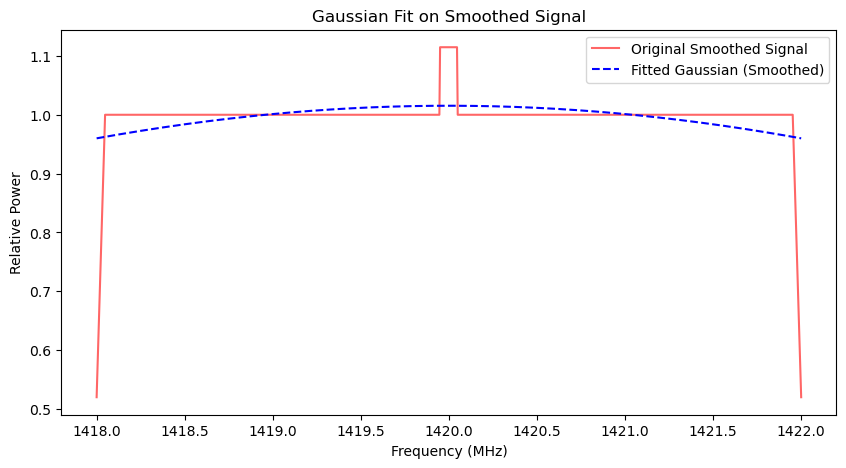

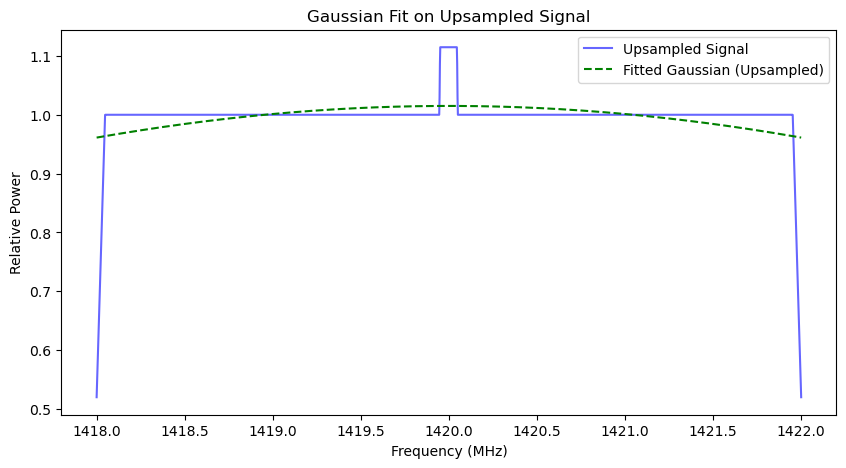

Gaussian parameters for smoothed signal:
Amplitude: 1.02, Mean (Center Frequency): 1420.00 MHz, Stddev: 5.97 MHz

Gaussian parameters for upsampled signal:
Amplitude: 1.02, Mean (Center Frequency): 1420.00 MHz, Stddev: 6.06 MHz


In [5]:
##STEP 5
from scipy.optimize import curve_fit

# 1. Define a Gaussian function to fit the spectral line
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# 2. Fit the Gaussian function to the smoothed signal
initial_guess = [3, 1420, 0.1]  # Initial guess for amplitude, mean, and standard deviation
popt_smoothed, _ = curve_fit(gaussian, frequency_range, smoothed_signal, p0=initial_guess)

# 3. Fit the Gaussian to the upsampled signal
popt_upsampled, _ = curve_fit(gaussian, new_frequency_range, upsampled_signal, p0=initial_guess)

# 4. Generate the fitted curves
fitted_smoothed_signal = gaussian(frequency_range, *popt_smoothed)
fitted_upsampled_signal = gaussian(new_frequency_range, *popt_upsampled)

# 5. Visualize the original smoothed signal and the fitted Gaussian
plt.figure(figsize=(10, 5))
plt.title('Gaussian Fit on Smoothed Signal')
plt.plot(frequency_range, smoothed_signal, label='Original Smoothed Signal', color='red', alpha=0.6)
plt.plot(frequency_range, fitted_smoothed_signal, label='Fitted Gaussian (Smoothed)', color='blue', linestyle='--')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

# Visualize the upsampled signal and the fitted Gaussian
plt.figure(figsize=(10, 5))
plt.title('Gaussian Fit on Upsampled Signal')
plt.plot(new_frequency_range, upsampled_signal, label='Upsampled Signal', color='blue', alpha=0.6)
plt.plot(new_frequency_range, fitted_upsampled_signal, label='Fitted Gaussian (Upsampled)', color='green', linestyle='--')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

# 6. Print the parameters of the fits
print("Gaussian parameters for smoothed signal:")
print(f"Amplitude: {popt_smoothed[0]:.2f}, Mean (Center Frequency): {popt_smoothed[1]:.2f} MHz, Stddev: {popt_smoothed[2]:.2f} MHz")

print("\nGaussian parameters for upsampled signal:")
print(f"Amplitude: {popt_upsampled[0]:.2f}, Mean (Center Frequency): {popt_upsampled[1]:.2f} MHz, Stddev: {popt_upsampled[2]:.2f} MHz")


Mean Squared Error for smoothed signal: 1.01063
Mean Squared Error for upsampled signal: 1.01121


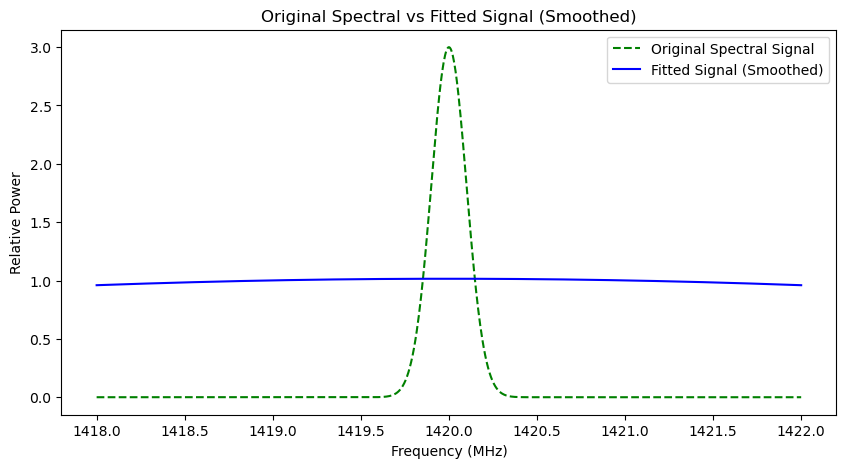

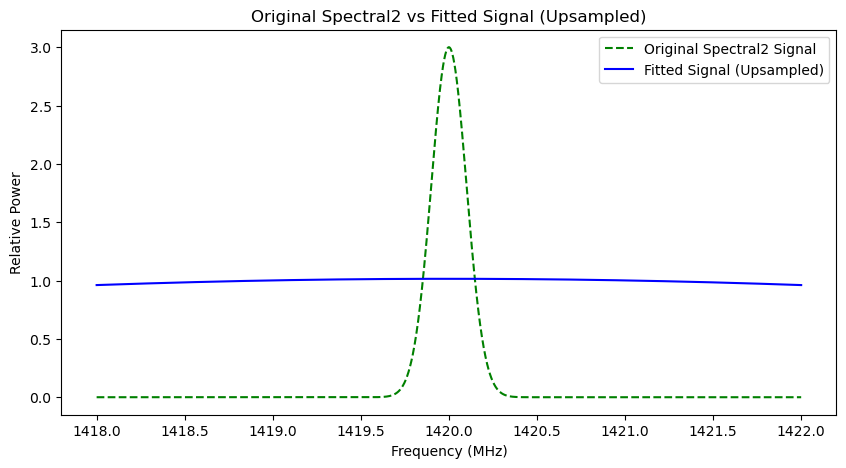

In [6]:
##STEP 6
from sklearn.metrics import mean_squared_error

# 1. Simulate the original "spectral" and "spectral2" signals (just the spectral line at 1420 MHz)
# For simplicity, we'll create a new Gaussian signal to represent the "spectral" signals
def generate_spectral_signal(freq_range, amp=3, mean=1420, stddev=0.1):
    return amp * np.exp(-((freq_range - mean) ** 2) / (2 * stddev ** 2))

# Generate the original spectral signals
spectral_signal = generate_spectral_signal(frequency_range)
spectral_signal2 = generate_spectral_signal(new_frequency_range)

# 2. Calculate the Mean Squared Error (MSE) between original and fitted signals
mse_smoothed = mean_squared_error(spectral_signal, fitted_smoothed_signal)
mse_upsampled = mean_squared_error(spectral_signal2, fitted_upsampled_signal)

print(f"Mean Squared Error for smoothed signal: {mse_smoothed:.5f}")
print(f"Mean Squared Error for upsampled signal: {mse_upsampled:.5f}")

# 3. Visualize the original spectral and fitted signals (for smoothed)
plt.figure(figsize=(10, 5))
plt.title('Original Spectral vs Fitted Signal (Smoothed)')
plt.plot(frequency_range, spectral_signal, label='Original Spectral Signal', color='green', linestyle='--')
plt.plot(frequency_range, fitted_smoothed_signal, label='Fitted Signal (Smoothed)', color='blue')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

# Visualize the original spectral and fitted signals (for upsampled)
plt.figure(figsize=(10, 5))
plt.title('Original Spectral2 vs Fitted Signal (Upsampled)')
plt.plot(new_frequency_range, spectral_signal2, label='Original Spectral2 Signal', color='green', linestyle='--')
plt.plot(new_frequency_range, fitted_upsampled_signal, label='Fitted Signal (Upsampled)', color='blue')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()


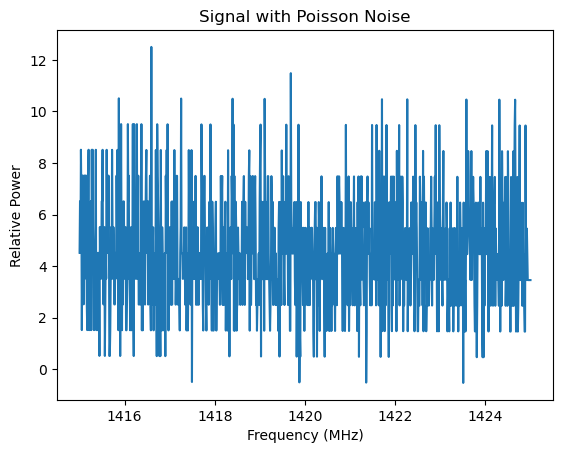

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from numpy.polynomial import Polynomial

# Step 1: Simulating a radio signal with Poisson noise

# Parameters
num_samples = 1000
frequency = np.linspace(1415, 1425, num_samples)  # Frequency domain (MHz)

# Create a background signal (non-linear) and Poisson noise
background_signal = np.sin(frequency / 1425 * 10)  # Background signal shape
poisson_noise = np.random.poisson(lam=5, size=num_samples)  # Poisson noise
signal_with_poisson_noise = background_signal + poisson_noise

# Visualize the original signal
plt.plot(frequency, signal_with_poisson_noise)
plt.title('Signal with Poisson Noise')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.show()

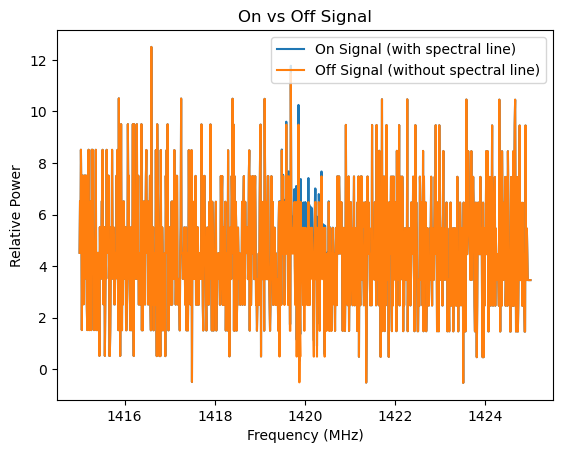

In [7]:
# Step 1b: Simulating the "on" signal with a spectral line at 1420 MHz
spectral_line = np.exp(-0.5 * ((frequency - 1420)/0.2)**2)  # Gaussian spectral line
on_signal = signal_with_poisson_noise + spectral_line

# Visualize the "on" signal with the spectral line
plt.plot(frequency, on_signal, label='On Signal (with spectral line)')
plt.plot(frequency, signal_with_poisson_noise, label='Off Signal (without spectral line)')
plt.title('On vs Off Signal')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()


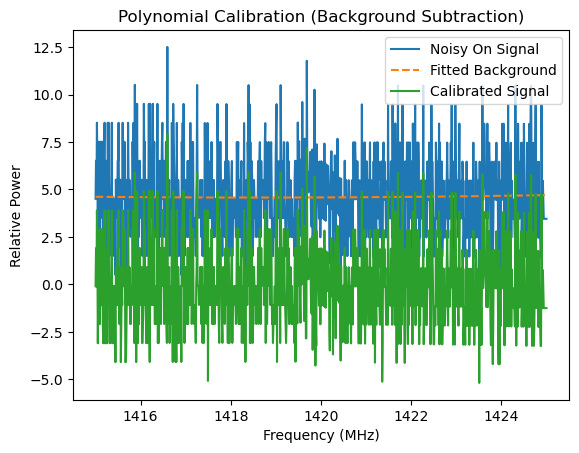

In [8]:
# Step 2: Background Calibration using Polynomial Fitting

# Polynomial fitting (degree 2)
p = Polynomial.fit(frequency, on_signal, deg=2)

# Subtracting the polynomial background from the noisy on-signal
calibrated_signal = on_signal - p(frequency)

# Visualize the calibrated signal
plt.plot(frequency, on_signal, label='Noisy On Signal')
plt.plot(frequency, p(frequency), label='Fitted Background', linestyle='--')
plt.plot(frequency, calibrated_signal, label='Calibrated Signal')
plt.title('Polynomial Calibration (Background Subtraction)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

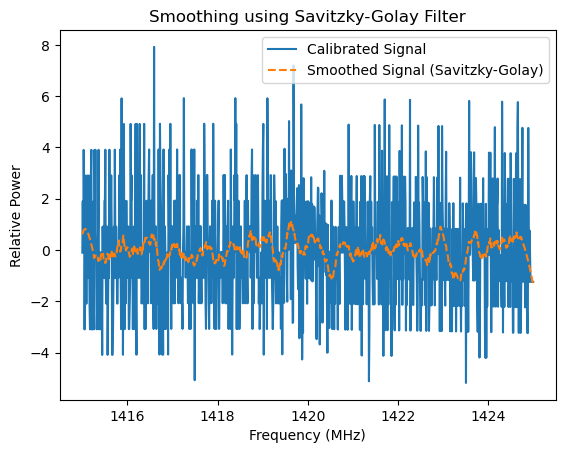

In [9]:
# Step 3: Smoothing using Savitzky-Golay Filter

# Applying Savitzky-Golay filter (window length = 51, polyorder = 3)
smooth_signal = savgol_filter(calibrated_signal, window_length=51, polyorder=3)

# Visualize the smoothed signal
plt.plot(frequency, calibrated_signal, label='Calibrated Signal')
plt.plot(frequency, smooth_signal, label='Smoothed Signal (Savitzky-Golay)', linestyle='--')
plt.title('Smoothing using Savitzky-Golay Filter')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

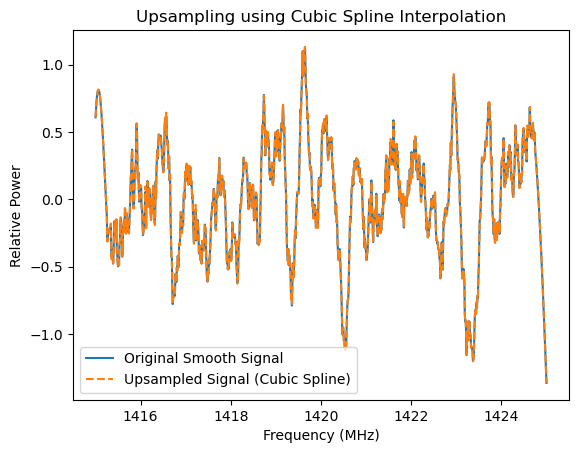

In [10]:
# Step 4: Upsampling using Cubic Spline Interpolation

# Original signal's frequency domain and smooth signal
num_samples = 1000
new_num_samples = 2000
frequency_original = np.linspace(1415, 1425, num_samples)

# Cubic spline interpolation for upsampling
cs = CubicSpline(frequency_original, smooth_signal)

# New frequency domain for upsampling
frequency_upsampled = np.linspace(1415, 1425, new_num_samples)
upsampled_signal = cs(frequency_upsampled)

# Visualize the upsampled signal
plt.plot(frequency_original, smooth_signal, label='Original Smooth Signal')
plt.plot(frequency_upsampled, upsampled_signal, label='Upsampled Signal (Cubic Spline)', linestyle='--')
plt.title('Upsampling using Cubic Spline Interpolation')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()


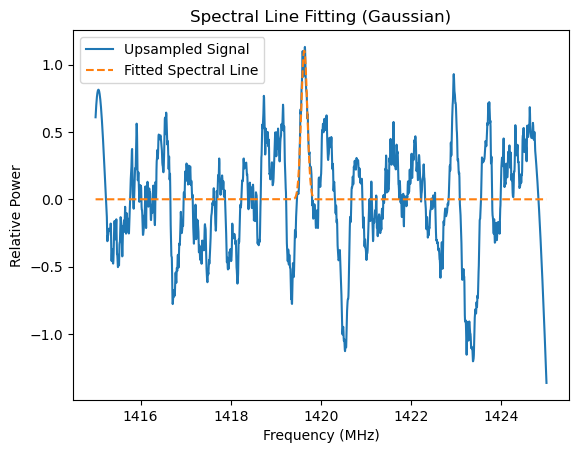

In [11]:
# Step 5: Spectral Line Fitting (Gaussian Fit example)

# Using the original spectral line to fit the signal
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-0.5 * ((x - mu) / sigma)**2)

from scipy.optimize import curve_fit

# Initial guess for Gaussian fit parameters: amplitude, mean (1420 MHz), std deviation
popt, _ = curve_fit(gaussian, frequency_upsampled, upsampled_signal, p0=[1, 1420, 0.2])

# Fitted spectral line
fitted_signal = gaussian(frequency_upsampled, *popt)

# Visualize the fitted signal
plt.plot(frequency_upsampled, upsampled_signal, label='Upsampled Signal')
plt.plot(frequency_upsampled, fitted_signal, label='Fitted Spectral Line', linestyle='--')
plt.title('Spectral Line Fitting (Gaussian)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

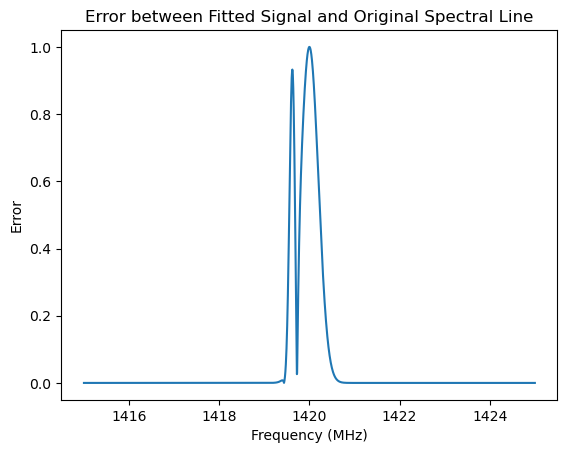

In [12]:
# Step 6: Error Estimation

# Calculate the error between the fitted signal and the original simulated spectral line
error = np.abs(fitted_signal - gaussian(frequency_upsampled, 1, 1420, 0.2))

# Visualize the error
plt.plot(frequency_upsampled, error)
plt.title('Error between Fitted Signal and Original Spectral Line')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Error')
plt.show()